# Predict low, high strategy  EDA

To install conda and binance packages to this notebook uncomment the code below

In [1]:
%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
%pip install binance-connector==1.13.0
%pip install pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
#mode="dev"
symbol="BTCUSDT"
mode="yc"
exchange="binance"
#strategy="SimpleKerasStrategy"
strategy="LSTMStrategy2"

In [3]:

import os

# Downloading latest pytrade2 data
if mode == "yc":
    os.system("cd ./../deploy/yandex_cloud; ./download_data.sh")
    data_dir=f"../data/yandex-cloud"
else:
    data_dir=f"../data/dev"
    
print(f"Download completed. Local data dir: {data_dir}")

    

receiving incremental file list
LSTMStrategy/LSTMStrategy.db
LSTMStrategy/Xy/2023-06-01_BTCUSDT_X.csv
LSTMStrategy/Xy/2023-06-01_BTCUSDT_data.csv
LSTMStrategy/Xy/2023-06-01_BTCUSDT_y.csv
LSTMStrategy/weights/2023-06-01T06:30:43.971264.data-00000-of-00001
LSTMStrategy/weights/2023-06-01T06:30:43.971264.index
LSTMStrategy/weights/checkpoint
LSTMStrategy2/LSTMStrategy2.db
LSTMStrategy2/Xy/2023-06-01_BTCUSDT_X.csv
LSTMStrategy2/Xy/2023-06-01_BTCUSDT_data.csv
LSTMStrategy2/Xy/2023-06-01_BTCUSDT_y.csv
LSTMStrategy2/weights/2023-06-01T06:30:56.148367.data-00000-of-00001
LSTMStrategy2/weights/2023-06-01T06:30:56.148367.index
LSTMStrategy2/weights/checkpoint
SimpleKerasStrategy/SimpleKerasStrategy.db
SimpleKerasStrategy/Xy/2023-06-01_BTCUSDT_X.csv
SimpleKerasStrategy/Xy/2023-06-01_BTCUSDT_data.csv
SimpleKerasStrategy/Xy/2023-06-01_BTCUSDT_y.csv
SimpleKerasStrategy/weights/2023-06-01T06:30:47.790928.data-00000-of-00001
SimpleKerasStrategy/weights/2023-06-01T06:30:47.790928.index
SimpleKerasStrat

Init binance client

In [4]:
from binance.spot import Spot as Client
import os
import sys
import yaml

def load_config(cfg_dir:str, paths:{})->{}:
    config={}
    for path in paths:
        fullpath=f"{cfg_dir}/{path}"
        with open(fullpath) as file:
            print("Reading config from "+fullpath)
            config.update(yaml.safe_load(file))
    return config

def load_config_local(strategy:str):
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    print("Reading local config")
    # Defaults
    cfg_dir="./../pytrade2/cfg"
    paths=["app-defaults.yaml", "app.yaml"]
    return load_config(cfg_dir, paths)

def load_config_yc(strategy):
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    print("Reading yc config")
    project_dir="./.."
    cfg_dir=f"{project_dir}/deploy/yandex_cloud/secret/"
    paths=["app.yaml", f"{strategy}.yaml"]
    return load_config(cfg_dir, paths)

def create_client(strategy: str, mode: str):
        """ Binance client creation """
        print(mode)
        # Read configs to get keys from there
        strategy=strategy.lower()
        config=load_config_local(strategy)
        if mode == "yc":
            config.update(load_config_yc(strategy))
        
        key,secret,url=config[f"pytrade2.exchange.{exchange}.connector.key"],config[f"pytrade2.exchange.{exchange}.connector.secret"],config[f"pytrade2.exchange.{exchange}.spot.url"]
        return Client(key=key, secret=secret, base_url=url, timeout=10)


client = create_client(strategy, mode)



yc
Reading local config
Reading config from ./../pytrade2/cfg/app-defaults.yaml
Reading config from ./../pytrade2/cfg/app.yaml
Reading yc config
Reading config from ./../deploy/yandex_cloud/secret//app.yaml
Reading config from ./../deploy/yandex_cloud/secret//lstmstrategy2.yaml


## Account and orders

### Account info

In [5]:
account=client.account()
usdt_free=[a["free"] for a in account["balances"] if a["asset"]=="USDT"]
# update_time=account["update_time"]
# print(f"account update time:{update_time}")
print(f"My USDT amount({strategy}): {usdt_free}")

print(account)
print(str(pd.to_datetime(account["updateTime"], unit="ms")))
# btc 1.15798200
#usdt 5134.30859706 26.04.2023 14:26
# usdt amount 
# 14.05.2023 9602.27USDT
# 14.05.2023 9613.27USDT
# 15.05.2023 12:11 10851.4496USDT
# 15.05.2023 15:26 USDT 10824.09131356, BTC 0.97100000
# 16.05.2023 19:12 USDT 10824.13392356 BTC 0.97100000
# 16.05.2023 22:09 USDT 10824.13237356, BTC 0.971
# 17.05.2023 0:47  USDT 10824.08461448 BTC 0.971
# 17.05.2023 9:44 USDT 10824.05857448 BTC 0.971
# 17.05.2023 17:22 USDT 10824.00134797 BTC 0.971
# 18.05.2023 08:25:81 USDT 10823.33222738 BTC 0.971
# 18.05.2023 23:09 USDT 10821.81933906 BTC 0.971
# 18.05.2023 07:22 USDT 10821.70723260 BTC 0.971 
# 19.05.2023 15:20 USDT 10820.82563494 locked 27.12356000 BTC 9.970
# 19.95.2023 15:25 USDT 10821.09770494 BTC 0.971

# Set sharp ratio=4
# 19.05.2023 19:36 USDT 10794.27474497 BTC 0.971
# 20.05.2023 15:35 USDT 10821.28357494 BTC 0.971



My USDT amount(LSTMStrategy2): ['10682.13542153']
{'makerCommission': 0, 'takerCommission': 0, 'buyerCommission': 0, 'sellerCommission': 0, 'commissionRates': {'maker': '0.00000000', 'taker': '0.00000000', 'buyer': '0.00000000', 'seller': '0.00000000'}, 'canTrade': True, 'canWithdraw': False, 'canDeposit': False, 'brokered': False, 'requireSelfTradePrevention': False, 'updateTime': 1685601057608, 'accountType': 'SPOT', 'balances': [{'asset': 'BNB', 'free': '1000.00000000', 'locked': '0.00000000'}, {'asset': 'BTC', 'free': '0.97500000', 'locked': '0.00000000'}, {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'}, {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'}, {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'}, {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'}, {'asset': 'USDT', 'free': '10682.13542153', 'locked': '27.08402000'}, {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}], 'permissions': ['SPOT']}

### Orders from Binance

In [6]:
def get_orders():
    orders = pd.DataFrame(client.get_orders(symbol))
    for timecol in ["time", "updateTime", "workingTime"]:
        orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
    return orders.set_index("time", drop=False)


get_orders().tail()


,symbol,orderId,orderListId,clientOrderId,price,origQty,executedQty,cummulativeQuoteQty,status,timeInForce,type,side,stopPrice,icebergQty,time,updateTime,isWorking,workingTime,origQuoteOrderQty,selfTradePreventionMode
time,,,,,,,,,,,,,,,,,,,,
2023-06-01 06:29:40.011,BTCUSDT,12852456,20139,mHRiiKtM2RlLJIPatFDL7u,27080.57000000,0.00100000,0.00100000,26.81266000,FILLED,GTC,STOP_LOSS_LIMIT,BUY,26812.48000000,0.00000000,2023-06-01 06:29:40.011,2023-06-01 06:30:57.608,True,2023-06-01 06:30:57.608,0.00000000,NONE
2023-06-01 06:29:40.011,BTCUSDT,12852457,20139,10vC1VGnbrpBzy0YUAYoBz,26791.87000000,0.00100000,0.00000000,0.00000000,EXPIRED,GTC,LIMIT_MAKER,BUY,0.00000000,0.00000000,2023-06-01 06:29:40.011,2023-06-01 06:30:57.608,True,2023-06-01 06:29:40.011,0.00000000,NONE
2023-06-01 06:30:00.523,BTCUSDT,12852560,-1,v4TVtaRZoOGhauBweHtHI8,26811.62000000,0.00100000,0.00100000,26.81162000,FILLED,FOK,LIMIT,SELL,0.00000000,0.00000000,2023-06-01 06:30:00.523,2023-06-01 06:30:00.523,True,2023-06-01 06:30:00.523,0.00000000,NONE
2023-06-01 06:30:00.803,BTCUSDT,12852565,20140,CSTbx1uFH9QgfqtgPRltqf,27084.02000000,0.00100000,0.00000000,0.00000000,NEW,GTC,STOP_LOSS_LIMIT,BUY,26815.90000000,0.00000000,2023-06-01 06:30:00.803,2023-06-01 06:30:00.803,False,1969-12-31 23:59:59.999,0.00000000,NONE
2023-06-01 06:30:00.803,BTCUSDT,12852566,20140,e8wkcWpB5r8wN67CMZ24qq,26782.73000000,0.00100000,0.00000000,0.00000000,NEW,GTC,LIMIT_MAKER,BUY,0.00000000,0.00000000,2023-06-01 06:30:00.803,2023-06-01 06:30:00.803,True,2023-06-01 06:30:00.803,0.00000000,NONE


### Opened orders from Binance

In [7]:
symbol="BTCUSDT"
orders=pd.DataFrame(client.get_open_orders(symbol))

for timecol in ["time", "updateTime", "workingTime"]:
    if timecol in orders.columns:
        orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
if "time" in orders.columns:
    orders.set_index("time", drop=False, inplace=True)
orders.tail()


,symbol,orderId,orderListId,clientOrderId,price,origQty,executedQty,cummulativeQuoteQty,status,timeInForce,type,side,stopPrice,icebergQty,time,updateTime,isWorking,workingTime,origQuoteOrderQty,selfTradePreventionMode
time,,,,,,,,,,,,,,,,,,,,
2023-06-01 06:30:00.803,BTCUSDT,12852565,20140,CSTbx1uFH9QgfqtgPRltqf,27084.02000000,0.00100000,0.00000000,0.00000000,NEW,GTC,STOP_LOSS_LIMIT,BUY,26815.90000000,0.00000000,2023-06-01 06:30:00.803,2023-06-01 06:30:00.803,False,1969-12-31 23:59:59.999,0.00000000,NONE
2023-06-01 06:30:00.803,BTCUSDT,12852566,20140,e8wkcWpB5r8wN67CMZ24qq,26782.73000000,0.00100000,0.00000000,0.00000000,NEW,GTC,LIMIT_MAKER,BUY,0.00000000,0.00000000,2023-06-01 06:30:00.803,2023-06-01 06:30:00.803,True,2023-06-01 06:30:00.803,0.00000000,NONE


### My trades from binance

In [8]:
symbol="BTCUSDT"
mytrades=pd.DataFrame(client.my_trades(symbol))
mytrades["time"] = pd.to_datetime(mytrades["time"], unit='ms')
mytrades.tail()


,symbol,id,orderId,orderListId,price,qty,quoteQty,commission,commissionAsset,time,isBuyer,isMaker,isBestMatch
495,BTCUSDT,4001909,12850798,20137,26829.31000000,0.00100000,26.82931000,0.00000000,BTC,2023-06-01 06:27:31.609,True,True,True
496,BTCUSDT,4001912,12850809,20138,26828.72000000,0.00100000,26.82872000,0.00000000,BTC,2023-06-01 06:27:32.605,True,True,True
497,BTCUSDT,4002221,12852451,-1,26809.46000000,0.00100000,26.80946000,0.00000000,USDT,2023-06-01 06:29:39.249,False,False,True
498,BTCUSDT,4002245,12852560,-1,26811.62000000,0.00100000,26.81162000,0.00000000,USDT,2023-06-01 06:30:00.523,False,False,True
499,BTCUSDT,4002304,12852456,20139,26812.66000000,0.00100000,26.81266000,0.00000000,BTC,2023-06-01 06:30:57.608,True,False,True


### Trades from bot database

In [9]:
import pandas as pd
import numpy as np

def get_trades(data_dir: str, strategy: str, mode: str):
    import sqlite3
    db_path=f"{data_dir}/{strategy}/{strategy}.db"
    print(f"Get trades from {db_path}")

    with sqlite3.connect(db_path) as conn:
        trades=pd.read_sql_query("SELECT * FROM trade ORDER BY open_time",conn,
                                 parse_dates=["open_time", "close_time"])#.set_index("open_time", drop=False)
    trades["profit"] = np.where(trades["side"] == "BUY", 
                                (trades["close_price"]-trades["open_price"])*trades["quantity"],
                                (trades["open_price"]-trades["close_price"])*trades["quantity"],
                               )
    trades["cum_profit"] = trades["profit"].cumsum()
    
    return trades

trades=get_trades(data_dir, strategy, mode)
trades.tail()

Get trades from ../data/yandex-cloud/LSTMStrategy2/LSTMStrategy2.db


,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,profit,cum_profit
534,535,BTCUSDT,BUY,2023-06-01 05:48:36.247,26855.44,12840597,26852.61,26866.09,"12840612,12840613",None,0.001,2023-06-01 05:48:40.490,26852.25,12840612,-0.00319,0.34627
535,536,BTCUSDT,BUY,2023-06-01 06:06:26.720,26855.86,12845644,26854.10,26861.56,"12845645,12845646",None,0.001,2023-06-01 06:08:04.532,26861.56,12845646,0.00570,0.35197
536,537,BTCUSDT,SELL,2023-06-01 06:11:51.786,26877.30,12847206,26880.33,26862.22,"12847211,12847212",None,0.001,2023-06-01 06:12:39.533,26882.62,12847211,-0.00532,0.34665
537,538,BTCUSDT,SELL,2023-06-01 06:24:25.699,26845.61,12850807,26848.08,26828.72,"12850808,12850809",None,0.001,2023-06-01 06:27:32.605,26828.72,12850809,0.01689,0.36354
538,539,BTCUSDT,SELL,2023-06-01 06:29:39.249,26809.46,12852451,26812.48,26791.87,"12852456,12852457",None,0.001,2023-06-01 06:30:57.608,26812.66,12852456,-0.00320,0.36034


In [10]:
print(f"Total profit: {trades['profit'].sum()}")


Total profit: 0.3603400000000474


### Opened trades from trade bot database

In [11]:
trades[trades.close_time.isna()].tail()

,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,profit,cum_profit


## Profit

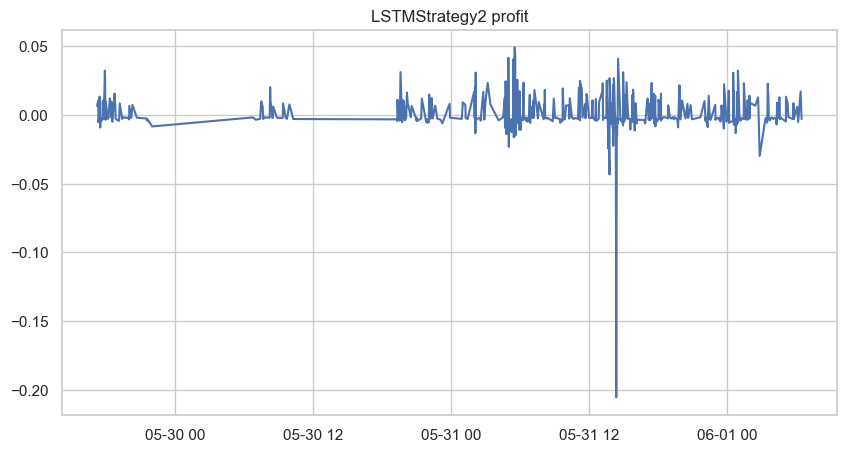

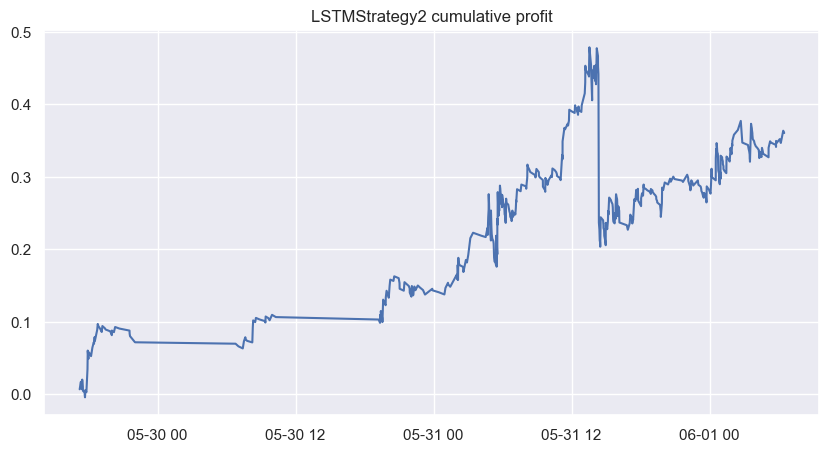

In [12]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_theme()
#paper, notebook, talk, poster

import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.renderers.default = "plotly_mimetype+notebook"
import plotly.graph_objects as go

    
plot_figsize=(10,5)


def plot_profits_plotly(trades):
    """ Plot profit charts using plotly"""
    px.line(trades, x="open_time", y="profit", title="Profit").update_traces(mode='lines+markers').show()
    px.line(trades, x="open_time", y="cum_profit", title=f"{strategy} cumulative profit").update_traces(mode='lines+markers').show()

def plot_profits_sns(trades):
    """ Plot profit charts using sns"""
    plt.figure(figsize=plot_figsize)
    sns.set_style("darkgrid")
    sns.lineplot(data=trades, x="open_time", y="profit").set_title(f"{strategy} profit")
    plt.show()

    #sns.set_palette("deep")
    sns.set_style("whitegrid")
    plt.figure(figsize=plot_figsize)
    sns.lineplot(data=trades, x="open_time", y="cum_profit").set_title( f"{strategy} cumulative profit")
    plt.show()
    
    # Cumulative profit w/o outliers
    profit=trades[["open_time","profit"]].set_index("open_time")
    q_low = profit["profit"].quantile(0.1)
    q_hi  = profit["profit"].quantile(0.9)
    profit_filtered = profit[(profit["profit"] < q_hi) & (profit["profit"] > q_low)]
    cumsum_filtered = profit_filtered.cumsum()
    plt.figure(figsize=plot_figsize)
    sns.set_style("darkgrid")
    sns.lineplot(data=cumsum_filtered).set_title(f"{strategy} profit w/o outliers")
    plt.show()

def plot_profits_plt(trades):
    """ Plot profits using matplotlib """
    plt.figure(figsize=(10,5))
    sns.set_style("whitegrid")
    plt.plot("open_time", "profit", data=trades)
    plt.title(f"{strategy} profit")
    plt.show()
    
    sns.set_style("darkgrid")
    plt.figure(figsize=(10,5))
    plt.plot("open_time", "cum_profit", data=trades)
    plt.title(f"{strategy} cumulative profit")
    plt.show()

plot_profits_plotly(trades)
#plot_profits_sns(trades[:-1:])
plot_profits_plt(trades)


Last orders, provided by Binance

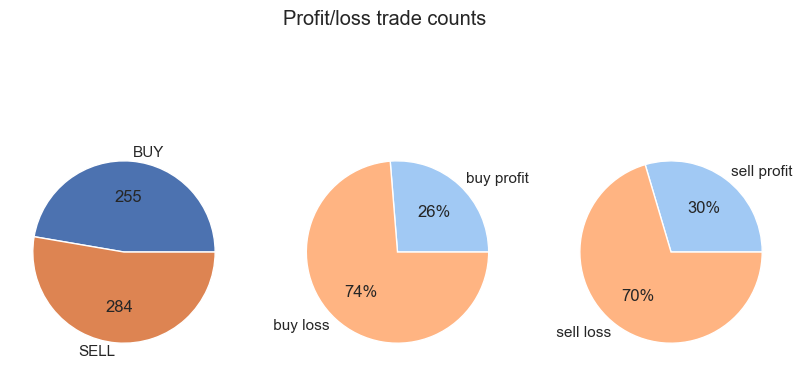

In [13]:
from matplotlib import pyplot as plt
import seaborn as sns


def plot_trade_counts(trades):
    buy_sell_counts = trades["side"].value_counts()
    total=len(trades)
    colors = sns.color_palette('pastel')[0:5]
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(plot_figsize)
    fig.suptitle('Profit/loss trade counts')
    # Buy/sell counts
    ax1.pie([len(trades[trades["side"]=="BUY"]),len(trades[trades["side"]=="SELL"])], 
            labels=["BUY","SELL"], \
            autopct=lambda p: '{:.0f}'.format(p * total / 100))
    # Buy profit/loss counts
    ax2.pie([len(trades[(trades["side"]=="BUY") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="BUY") &  (trades["profit"]<0)].index) \
            ],
            labels=["buy profit", " buy loss"], autopct="%.0f%%", colors=colors)
    # Sell profit/loss counts
    ax3.pie([len(trades[(trades["side"]=="SELL") &  (trades["profit"]>0)].index),\
            len(trades[(trades["side"]=="SELL") &  (trades["profit"]<0)].index) \
            ],
            labels=["sell profit", " sell loss"], autopct="%.0f%%", colors=colors)

    
plot_trade_counts(trades)



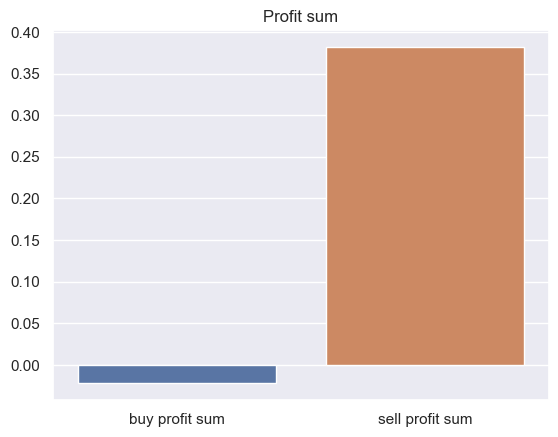

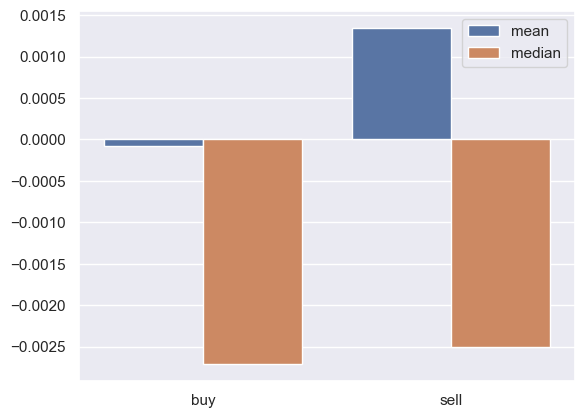

In [14]:
import plotly.express as px

def plot_profit_stat_plotly(trades):
    """ Profit statistics: summary, average """
    buy_profit = trades.loc[trades["side"]=="BUY","profit"]
    sell_profit = trades.loc[trades["side"]=="SELL","profit"]
    px.bar(x=["buy_profit_sum", "sell_profit_sum"], y=[buy_profit.sum(), sell_profit.sum()], title="Buy/sell profit sum").show()
    px.bar(x=["buy_profit_mean", "sell_profit_mean"], y=[buy_profit.mean(), sell_profit.mean()], title="Buy/sell mean profit").show()

def plot_profit_stat_sns(trades):
    """ Profit statistics: summary, average """
    buy_profit = trades.loc[trades["side"]=="BUY","profit"]
    sell_profit = trades.loc[trades["side"]=="SELL","profit"]
    buy_profit_mean, sell_profit_mean = buy_profit.mean(), sell_profit.mean()
    buy_profit_mdn, sell_profit_mdn = buy_profit.median(), sell_profit.median()
    
    sns.barplot(x=["buy profit sum", "sell profit sum"], y = [buy_profit.sum(), sell_profit.sum()])
    plt.title("Profit sum")
    plt.show()
    #sns.set_style("whitegrid")
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(plot_figsize)
#     fig.align_ylabels(ax2)    

    data={"val": [buy_profit.mean(), sell_profit.mean(), buy_profit.median(), sell_profit.median()],
          "type": ["buy", "sell", "buy", "sell"],
          "agg": ["mean", "mean", "median", "median"]
         }
    sns.barplot(data=data, x="type", y="val", hue="agg")
    #sns.barplot(x=["buy profit median", "sell profit median"], y = [buy_profit.median(), sell_profit.median()],ax=ax2)
    #fig.show()
    
#     px.bar(x=["buy_profit_sum", "sell_profit_sum"], y=[buy_profit.sum(), sell_profit.sum()], title="Buy/sell profit sum").show()
#     px.bar(x=["buy_profit_mean", "sell_profit_mean"], y=[buy_profit.mean(), sell_profit.mean()], title="Buy/sell mean profit").show()
    
plot_profit_stat_sns(trades)

## Trades on candlestick chart

In [15]:
from datetime import datetime
def get_last_candles():
    candle_columns = ["open_time", "open", "high", "low", "close", "vol", "close_time", "quote_asset_volume",
                      "number_of_trades", " taker_buy_base_asset_volume", "taker_buy_quote_asset_volume",
                      "ignore"]    
    end_date=trades.open_time.max() if not trades.empty else datetime.utcnow()
    
    #end_time_millis=end_date.value//1000000
    cnt=24*60 # Number of last candles to read
    raw_candles = client.klines(symbol=symbol,
                                    interval="1m",
                                    #limit=10,
                                    limit=cnt,
                                    #endTime=end_time_millis
                               )
    df = pd.DataFrame(raw_candles, columns=candle_columns)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df.set_index("open_time", drop=False, inplace=True)
        # Convert strings to float prices
    df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].astype(float)
    return df

def clean_candles(df):
    """ Remove outliers """
    q_low = df["low"].diff().quantile(0.1)
    q_high  = df["high"].diff().quantile(0.9)
    df=df[df["high"].diff()< q_high]
    df=df[df["low"].diff() > q_low ]
    return df

candles = get_last_candles()
candles = clean_candles(candles)
candles.tail()

,open_time,open,high,low,close,vol,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
open_time,,,,,,,,,,,,
2023-06-01 06:26:00,2023-06-01 06:26:00,26837.90,26838.43,26831.45,26831.45,2.57540900,2023-06-01 06:26:59.999,69109.14541823,99,0.68908300,18491.09121269,0
2023-06-01 06:27:00,2023-06-01 06:27:00,26831.39,26831.39,26826.50,26826.50,1.95484800,2023-06-01 06:27:59.999,52446.04925070,83,0.02677100,718.24719977,0
2023-06-01 06:28:00,2023-06-01 06:28:00,26826.51,26827.57,26820.08,26820.08,3.22406800,2023-06-01 06:28:59.999,86483.50984917,109,1.15724400,31044.88654962,0
2023-06-01 06:30:00,2023-06-01 06:30:00,26811.62,26812.93,26808.68,26812.93,2.07296600,2023-06-01 06:30:59.999,55578.07159633,72,1.53960300,41278.87026569,0
2023-06-01 06:31:00,2023-06-01 06:31:00,26811.51,26817.09,26811.46,26817.09,1.82559200,2023-06-01 06:31:59.999,48952.40970596,84,1.60007200,42905.76454978,0


In [ ]:
# Install a conda package in the current Jupyter kernel
#%conda install -c plotly plotly=5.9.0
# Draw candlechart
import plotly as py
from plotly import graph_objects as go
import pandas as pd
import numpy as np
import datetime

def get_chart_figure(candles: pd.DataFrame, trades: pd.DataFrame)->pd.DataFrame:
    """
    Form plotly candlestick chart with buy/sell marks on it
    """
    
    df=candles.copy()
    #df=clean_candles(df)
    fig = go.Figure(data=[ \
                        go.Candlestick(\
                            x=df.index,\
                            open=df['open'],\
                            high=df['high'],\
                            low=df['low'],\
                            close=df['close'])
                         ])

    # Customize ay to distribute captions by y so they do not overlap by x
    ay,aymax,aystep=0,50,10
    #start_time=df.open_time.min()
    # Annotate buy, sell on the chart
    for i,trade in trades[(~trades.open_time.isna()) & (trades.open_time > df.open_time.min())].iterrows():
        ay=(ay+aystep)%aymax
        color='green' if trade['side']=="BUY" else 'red'

        # Draw open order
        open_text='buy' if trade['side']=="BUY"  else 'sell'
        open_hover=f"{trade['open_time']} {open_text} at {str(trade['open_price'])}, sl={trade['stop_loss_price']}, tp={trade['take_profit_price']}"
        fig.add_annotation(x=trade['open_time'], \
                           y=trade['open_price'],\
                           text=open_text,\
                           hovertext=open_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                          )
    for i,trade in trades[(~trades.close_time.isna()) & (trades.close_time > df.close_time.min())].iterrows():
        color='green' if trade['side']=="BUY" else 'red'

        # Draw close order
        #profit = trade["close_price"]-trade["open_price"] if trade["close_price"] else None
        status= f", profit: {round(trade.profit, 10)}" if trade.profit else ""
        close_text='close buy' if trade['side']=="BUY"  else 'close sell'
        close_hover=f"{trade['close_time']} {close_text} at {str(trade['close_price'])}{status}"
        fig.add_annotation(x=trade['close_time'], \
                           y=trade['close_price'],\
                           text=close_text,\
                           hovertext=close_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                          )
    return fig

get_chart_figure(candles, trades).show()



## Predicted and actual low/high

In [17]:
import os
import glob
import pandas as pd
from datetime import timedelta,date
import matplotlib.pyplot as plt
import plotly.express as px

def read_last_data(data_dir, strategy):
    """ Read days from start to end from local predictions history"""
    
    def read_last(symbol: str, name: str, n: int):
        xy_dir=f"{data_dir}/{strategy}/Xy"
        file_path = sorted([f for f in os.listdir(xy_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
        return pd.read_csv(f"{xy_dir}/{file_path}", parse_dates=True, index_col="datetime").tail(n)
    n=1000
    data=read_last("BTCUSDT", "data", n)
    X=read_last("BTCUSDT", "X", n)
    y=read_last("BTCUSDT", "y", n)
    data=pd.merge(data[["symbol"]],y, left_index=True, right_index=True) 
    #y=pd.concat([data,y])
    return data,X,y


# Read candles for last 3 days
data,_,_ = read_last_data(data_dir, strategy)
data.tail(100)

,symbol,bid,ask,bid_max_fut,bid_min_fut,ask_min_fut,ask_max_fut,predict_window,open_signal,cur_trade
datetime,,,,,,,,,,
2023-06-01 06:30:19.342027,BTCUSDT,26810.19,26810.20,26810.190372,26786.525615,26786.001836,26806.221736,60s,0,-1
2023-06-01 06:30:19.488209,BTCUSDT,26810.19,26810.20,26810.190372,26786.525615,26786.001836,26806.221736,60s,0,-1
2023-06-01 06:30:19.631684,BTCUSDT,26810.19,26810.20,26810.190372,26786.525615,26786.001836,26806.221736,60s,0,-1
2023-06-01 06:30:19.776267,BTCUSDT,26810.19,26810.20,26810.190372,26786.525615,26786.001836,26806.221736,60s,0,-1
2023-06-01 06:30:19.941642,BTCUSDT,26810.19,26810.20,26810.190372,26786.525615,26786.001836,26806.221736,60s,0,-1
...,...,...,...,...,...,...,...,...,...,...
2023-06-01 06:30:42.725284,BTCUSDT,26808.68,26808.69,26808.724879,26802.246393,26797.845967,26803.544570,60s,0,-1
2023-06-01 06:30:42.970969,BTCUSDT,26808.68,26808.69,26808.784355,26802.247796,26797.880180,26803.631263,60s,0,-1
2023-06-01 06:30:43.218360,BTCUSDT,26808.68,26808.69,26808.545647,26802.339964,26798.157289,26803.823489,60s,0,-1


In [18]:

def get_predictions(data):
    """ 
    Merge predicted and real prices for analysis 
    """
    
    # Prediction window is constant, get it from last row
    predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
    predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
    predict_window=data["predict_window"].tail(1).values[0]
    real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
    real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
    real=pd.concat([real_min, real_max], axis=1)
    real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)
    merged=pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True, direction='forward')
    return merged[["bid", "ask", "bid_min_real", "bid_min_predicted", "bid_max_real", "bid_max_predicted", \
                   "ask_min_real", "ask_min_predicted", "ask_max_real", "ask_max_predicted"]]


# predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
# predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
# predict_window=data["predict_window"].tail(1).values[0]
# real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
# real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
# real=pd.concat([real_min, real_max], axis=1)
# real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)

# pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True, direction='backward')


predictions = get_predictions(data)
predictions.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-06-01 06:26:39.322027 to 2023-06-01 06:30:43.704931
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bid                1000 non-null   float64
 1   ask                1000 non-null   float64
 2   bid_min_real       1000 non-null   float64
 3   bid_min_predicted  1000 non-null   float64
 4   bid_max_real       1000 non-null   float64
 5   bid_max_predicted  1000 non-null   float64
 6   ask_min_real       1000 non-null   float64
 7   ask_min_predicted  1000 non-null   float64
 8   ask_max_real       1000 non-null   float64
 9   ask_max_predicted  1000 non-null   float64
dtypes: float64(10)
memory usage: 85.9 KB


## Prediction errors

In [19]:
def plot_prediction_err(predictions):
    df = pd.DataFrame(index=predictions.index)
    for bidask in ["bid", "ask"]:
        for maxmin in ["max", "min"]:
            prefix = f"{bidask}_{maxmin}"
            df[f"{prefix}_error"] = predictions[f"{prefix}_predicted"] - predictions[f"{prefix}_real"]
    
    px.line(df, title="Errors", markers=True).show()
    px.line(df.sum(axis=1).abs().rename("error sum"), title="Error summary", markers=True).show()
    
plot_prediction_err(predictions)

In [20]:
import pandas as pd

def get_profits(predictions: pd.DataFrame)->pd.DataFrame:
    """
    Buy, sell profit, real and predicted, for each time moment
    """
    
    profits = pd.DataFrame()
    # Profit/loss ratio to consider buy or sell
    min_ratio=2

    # Calculate possible profits for buy or sell
    profits["buy_profit_predicted"] = predictions["bid_max_predicted"] - predictions["ask"]
    profits["buy_loss_predicted"] = predictions["ask"]-predictions["bid_min_predicted"]
    profits['buy_ratio_predicted'] = np.where(profits['buy_loss_predicted'] > 0, profits['buy_profit_predicted'] / profits['buy_loss_predicted'],float('inf'))

    profits["buy_profit_real"] = predictions["bid_max_real"] - predictions["ask"]
    profits["buy_loss_real"] = predictions["ask"]-predictions["bid_min_real"]
    profits['buy_ratio_real'] = np.where(profits['buy_loss_real'] > 0, profits['buy_profit_real'] / profits['buy_loss_real'],float('inf'))


    profits["sell_profit_predicted"] = predictions["bid"] - predictions["ask_min_predicted"]
    profits["sell_loss_predicted"] = predictions["ask_max_predicted"] - predictions["bid"]
    profits['sell_ratio_predicted'] = np.where(profits['sell_loss_predicted'] > 0, profits['sell_profit_predicted'] / profits['sell_loss_predicted'],float('inf'))

    profits["sell_profit_real"] = predictions["bid"] - predictions["ask_min_real"]
    profits["sell_loss_real"] = predictions["ask_max_real"] - predictions["bid"]
    profits['sell_ratio_real'] = np.where(profits['sell_loss_real'] > 0, profits['sell_profit_real'] / profits['sell_loss_real'],float('inf'))


    profits["signal"] = np.where(profits['buy_ratio_predicted'] >= min_ratio, 1,
                                 np.where(profits["sell_ratio_predicted"]>=min_ratio, -1,0 ))

    # Calculate real profit or loss
    profits["profit_real"] = np.where(
        # If buy                             
        profits["signal"]==1,
        np.where(
            # Real movement down was inside what we predicted
            (predictions["bid_min_real"] < predictions["bid_min_predicted"]) 
            & (predictions["bid_max_real"] <= predictions["bid_max_predicted"]),
            # Take the profit
            profits["buy_profit_predicted"],
            # Or fix the loss
            -profits["buy_loss_predicted"]
        ),
        # If Sell                     
        np.where(profits["signal"] == -1,
            np.where(
                # Real movement down was inside what we predicted
                (predictions["ask_max_real"] > predictions["ask_max_predicted"]) 
                & (predictions["ask_min_real"] >= predictions["ask_max_predicted"]),
                # Take the profit
                profits["sell_profit_predicted"],
                # Or fix the loss
                -profits["sell_loss_predicted"]
            ),
            # If neither buy nor sell, return NaN
            np.nan
        )
    )

    # Fill in predicted profit
    profits["profit_predicted"]=np.where(profits["signal"] == 1, 
                                         # If buy
                                         profits["buy_profit_predicted"], 
                                        np.where(profits["signal"]==-1,
                                                # If sell
                                                profits["sell_profit_predicted"],
                                                # If neither buy not sell
                                                 np.nan))
    return profits

profits = get_profits(predictions)
pd.set_option('display.max_rows', 1000)
pd.concat([predictions,profits],axis=1).tail()
#profits.dropna().tail(100)




,bid,ask,bid_min_real,bid_min_predicted,bid_max_real,bid_max_predicted,ask_min_real,ask_min_predicted,ask_max_real,ask_max_predicted,buy_profit_predicted,buy_loss_predicted,buy_ratio_predicted,buy_profit_real,buy_loss_real,buy_ratio_real,sell_profit_predicted,sell_loss_predicted,sell_ratio_predicted,sell_profit_real,sell_loss_real,sell_ratio_real,signal,profit_real,profit_predicted
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2023-06-01 06:30:42.725284,26809.46,26809.47,26808.68,26788.435644,26811.62,26809.486202,26808.69,26786.196305,26811.63,26805.362786,0.016202,21.034356,0.00077,2.15,0.79,2.721519,23.263695,-4.097214,inf,0.77,2.17,0.354839,-1,23.263695,23.263695
2023-06-01 06:30:42.970969,26809.46,26809.47,26808.68,26790.298399,26811.62,26809.462910,26808.69,26783.565190,26811.63,26801.900496,-0.007090,19.171601,-0.00037,2.15,0.79,2.721519,25.894810,-7.559504,inf,0.77,2.17,0.354839,-1,25.894810,25.894810
2023-06-01 06:30:43.218360,26809.46,26809.47,26808.68,26790.298399,26811.62,26809.462910,26808.69,26783.565190,26811.63,26801.900496,-0.007090,19.171601,-0.00037,2.15,0.79,2.721519,25.894810,-7.559504,inf,0.77,2.17,0.354839,-1,25.894810,25.894810
2023-06-01 06:30:43.459371,26809.46,26809.47,26808.68,26790.298399,26811.62,26809.462910,26808.69,26783.565190,26811.63,26801.900496,-0.007090,19.171601,-0.00037,2.15,0.79,2.721519,25.894810,-7.559504,inf,0.77,2.17,0.354839,-1,25.894810,25.894810
2023-06-01 06:30:43.704931,26809.46,26809.47,26808.68,26790.298399,26811.62,26809.462910,26808.69,26783.565190,26811.63,26801.900496,-0.007090,19.171601,-0.00037,2.15,0.79,2.721519,25.894810,-7.559504,inf,0.77,2.17,0.354839,-1,25.894810,25.894810


In [21]:
print(f"Total prediction profit sum: {profits['profit_real'].sum()}")



Total prediction profit sum: 1262.068713015764


In [22]:
#px.line(profits[["profit_predicted", "profit_real"]], markers=True)
px.line(profits["profit_predicted"]-profits["profit_real"])

## Sharp ratio

In [23]:
sharp_ratio_df=profits[["buy_ratio_predicted", "buy_ratio_real", "sell_ratio_predicted", "sell_ratio_real"]]
sharp_ratio_df.tail()


,buy_ratio_predicted,buy_ratio_real,sell_ratio_predicted,sell_ratio_real
datetime,,,,
2023-06-01 06:30:42.725284,0.00077,2.721519,inf,0.354839
2023-06-01 06:30:42.970969,-0.00037,2.721519,inf,0.354839
2023-06-01 06:30:43.218360,-0.00037,2.721519,inf,0.354839
2023-06-01 06:30:43.459371,-0.00037,2.721519,inf,0.354839
2023-06-01 06:30:43.704931,-0.00037,2.721519,inf,0.354839


In [24]:
px.line(sharp_ratio_df[["buy_ratio_predicted", "buy_ratio_real"]], title="Buy sharp ratio")

In [25]:
px.line(sharp_ratio_df[["sell_ratio_predicted", "sell_ratio_real"]], title="Sell sharp ratio")